# Prepares observational datasets to be use for Fay and McKinley 2014 ocean biome calculations

In [1]:
%matplotlib inline
# import warnings
# warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

import pandas as pd

import xesmf #for regridding
xr.set_options(keep_attrs=True)
import regionmask #for generating 1° ocean mask

### Make a standard 1° ones masks for masking, etc. (one for lons -180 to 180 and one for lons 0 to 360)

In [2]:
ones = np.full((180,360),1,dtype=int)
ones = xr.DataArray(ones,dims=('lat','lon'))
ones['lat'] = np.arange(-89.5, 90, 1)
ones['lon'] = np.arange(-179.5, 180, 1)

In [3]:
ones2 = np.full((180,360),1,dtype=int)
ones2 = xr.DataArray(ones2,dims=('lat','lon'))
ones2['lat'] = np.arange(-89.5, 90, 1)
ones2['lon'] = np.arange(0.5, 360, 1)

In [4]:
# Define the 1-degree latitude and longitude points
lon = np.arange(-179.5, 180, 1)
lat = np.arange(-89.5, 90, 1)

# Create the land mask using Natural Earth data (default resolution is 1:110m)
# The mask will be boolean (True for land) on the specified grid
land_mask = regionmask.defined_regions.natural_earth_v5_1_2.land_110.mask(lon, lat)
land_mask = land_mask.where(land_mask==0, other=1)

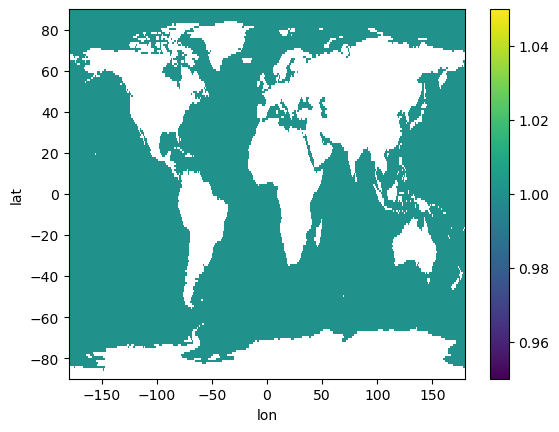

In [5]:
ones = ones.where(land_mask==1)
ones.plot()

# Read in observational data monthly climatologies and then regrid to 1°

## Argo MLD
### (perhaps replace Argo MLD with this: https://www.seanoe.org/data/00806/91774/)

In [6]:
file = '/glade/work/kristenk/Argo_MLD/Argo_mixedlayers_monthlyclim_04142022.nc'

MLD_clim_ds = xr.open_dataset(file)

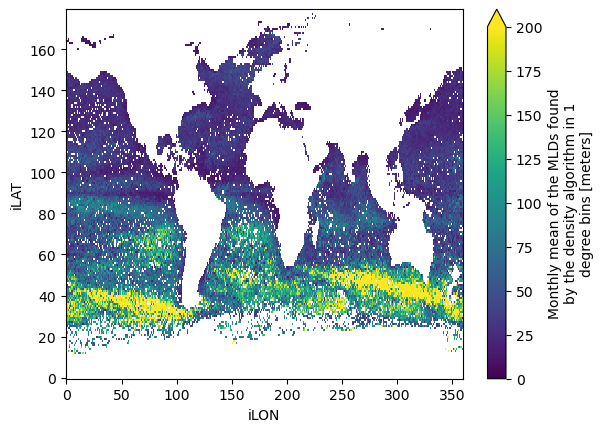

In [7]:
MLD_clim_ds.mld_da_mean.isel(iMONTH=8).plot(vmin=0,vmax=200)

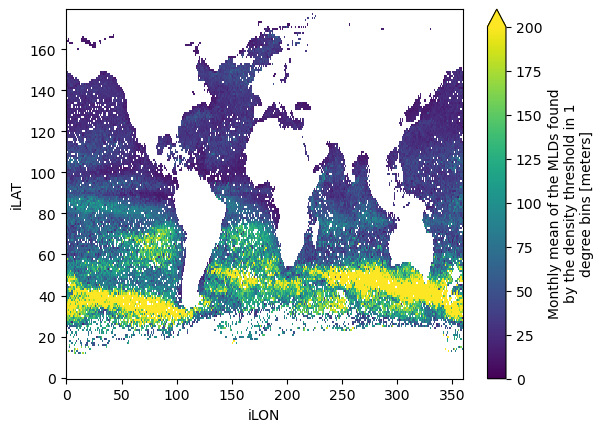

In [8]:
MLD_clim_ds.mld_dt_mean.isel(iMONTH=8).plot(vmin=0,vmax=200)

In [9]:
MLD_clim_ds = MLD_clim_ds.rename({'iLAT':'lat', 'iLON':'lon', 'iMONTH':'month'})

### create ds with all the good vars for biomes

In [10]:
ds = xr.Dataset()
ds = ds.assign_coords({"lon": MLD_clim_ds.lon.values})
ds = ds.assign_coords({"lat": MLD_clim_ds.lat.values})
ds = ds.assign_coords({"month": MLD_clim_ds.month.values})

ds['MLD'] = MLD_clim_ds.mld_dt_mean


ds

<xarray.Dataset> Size: 6MB
Dimensions:  (lon: 360, lat: 180, month: 12)
Coordinates:
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * month    (month) float64 96B 1.0 2.0 3.0 4.0 5.0 ... 8.0 9.0 10.0 11.0 12.0
Data variables:
    MLD      (lat, lon, month) float64 6MB ...

## Chlorophyll  from MODIS

In [11]:
tlen = 18
ny = 2160
nx = 4320

path = '/glade/work/kristenk/satellite_data/Monthly_clim_chlor_a/new/'


files = ['AQUA_MODIS.20030101_20250131.L3m.MC.CHL.chlor_a.9km.nc', 'AQUA_MODIS.20030201_20250228.L3m.MC.CHL.chlor_a.9km.nc',
         'AQUA_MODIS.20030301_20250331.L3m.MC.CHL.chlor_a.9km.nc', 'AQUA_MODIS.20030401_20250430.L3m.MC.CHL.chlor_a.9km.nc',
         'AQUA_MODIS.20030501_20250531.L3m.MC.CHL.chlor_a.9km.nc', 'AQUA_MODIS.20030601_20250630.L3m.MC.CHL.chlor_a.9km.nc',
         'AQUA_MODIS.20020701_20250731.L3m.MC.CHL.chlor_a.9km.nc', 'AQUA_MODIS.20020801_20250831.L3m.MC.CHL.chlor_a.9km.nc',
         'AQUA_MODIS.20020901_20250930.L3m.MC.CHL.chlor_a.9km.nc', 'AQUA_MODIS.20021001_20251031.L3m.MC.CHL.chlor_a.9km.nc', 
         'AQUA_MODIS.20021101_20251130.L3m.MC.CHL.chlor_a.9km.nc', 'AQUA_MODIS.20021201_20241231.L3m.MC.CHL.chlor_a.9km.nc']


tlen=len(files)

modis_chl = np.full((tlen,ny,nx),-9999.)

t = 0
for file in files:
    ds_tmp = xr.open_dataset(path + file)
    modis_chl[t,:,:] = np.flipud(ds_tmp.chlor_a.values)
    t = t + 1

chl_attrs = ds_tmp.chlor_a.attrs

modis_chl = xr.DataArray(modis_chl, dims=('time','lat','lon'))

ds_sat_chl = xr.Dataset()
ds_sat_chl['chl'] = modis_chl

lat_data = np.arange(-90+1/24,90,1/12)
lon_data = np.arange(-180+1/24,180,1/12)

ds_sat_chl['lat'] = lat_data
ds_sat_chl['lon'] = lon_data
ds_sat_chl.chl.attrs = chl_attrs

#### Regrid Chl to regular 1° grid

In [12]:
def regrid_chl(ds_in, varname):
    
    lon = ds.lon.values
    lat = ds.lat.values
    
    ds_out = xr.Dataset({"lon": (["lon"], lon),"lat": (["lat"], lat)})

    #ds_in = ds_in.assign_coords(lat=grid_in.lat, lat_b=grid_in.lat_b, lon=grid_in.lon, lon_b=grid_in.lon_b)
    #ds_in = ds_in.assign_coords(lat=ds.lat, lon=ds.lon)
    
    def regrid_tracer(varname, ds_in, ds_out, method='bilinear'):
    
        regrid = xesmf.Regridder(
            ds_in,
            ds_out,
            method=method,
            periodic=True,
        )
        fld_out = regrid(ds_in[varname])
        return fld_out

    var_1x1 = regrid_tracer(varname, ds_in, ds_out)

    return(var_1x1)

In [13]:
chl = regrid_chl(ds_sat_chl, 'chl')
chl.attrs = chl_attrs

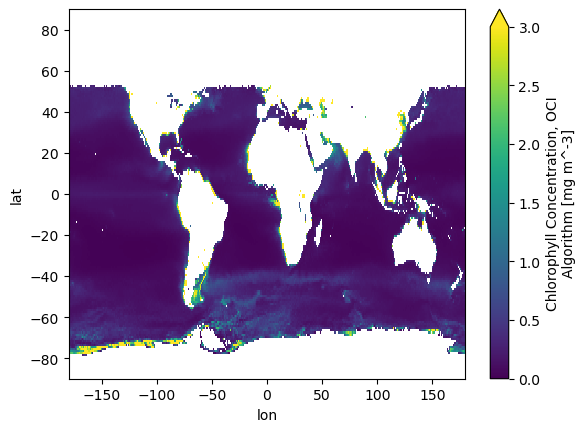

In [14]:
chl.isel(time=0).plot(vmin=0,vmax=3)

In [15]:
chl = chl.rename({'time':'month'})

In [16]:
ds['Chl'] = chl.transpose("lat", "lon","month")

ds

<xarray.Dataset> Size: 12MB
Dimensions:  (lon: 360, lat: 180, month: 12)
Coordinates:
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * month    (month) float64 96B 1.0 2.0 3.0 4.0 5.0 ... 8.0 9.0 10.0 11.0 12.0
Data variables:
    MLD      (lat, lon, month) float64 6MB ...
    Chl      (lat, lon, month) float64 6MB nan nan nan nan ... nan nan nan nan

## Sea ice observations from Climate Data Record

In [17]:
file1 = '/glade/derecho/scratch/landrum/SSMI_CDR/ice/seaice_conc_clim_nh.CDR.1979-2021.nc'
file2 = '/glade/derecho/scratch/landrum/SSMI_CDR/ice/seaice_conc_clim_sh.CDR.1979-2021.nc'

nh_ice = xr.open_dataset(file1)
sh_ice = xr.open_dataset(file2)

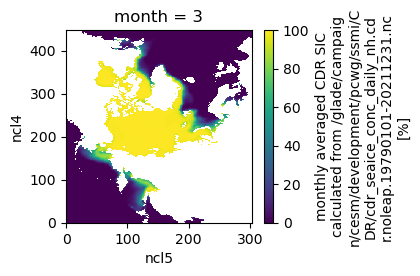

In [18]:
nh_ice.sic_clim.isel(month=3).plot(figsize=(3,2.5))

In [19]:
ice_attrs = nh_ice.sic_clim.attrs
ice_attrs['long_name'] = 'monthly averaged CDR SIC'

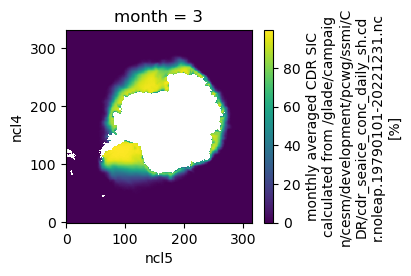

In [20]:
sh_ice.sic_clim.isel(month=3).plot(figsize=(3,2.5))

In [21]:
def regrid_ice(ds_in, varname):
    
    lon = np.arange(0.5, 360, 1)
    lat = np.arange(-89.5, 90, 1)
    
    ds_out = xr.Dataset({"lon": (["lon"], lon),"lat": (["lat"], lat)})

    def regrid_tracer(varname, ds_in, ds_out, method='bilinear'):
    
        regrid = xesmf.Regridder(
            ds_in,
            ds_out,
            method=method,
            #periodic=True,
        )
        fld_out = regrid(ds_in[varname])
        return fld_out

    var_1x1 = regrid_tracer(varname, ds_in, ds_out)

    return(var_1x1)

/glade/u/apps/opt/miniforge/envs/npl-2026a/lib/python3.13/site-packages/xesmf/frontend.py:788: UserWarning: Using dimensions ('ncl4', 'ncl5') from data variable sic_clim as the horizontal dimensions for the regridding.
  warnings.warn(
/glade/u/apps/opt/miniforge/envs/npl-2026a/lib/python3.13/site-packages/xesmf/frontend.py:788: UserWarning: Using dimensions ('ncl4', 'ncl5') from data variable sic_clim as the horizontal dimensions for the regridding.
  warnings.warn(


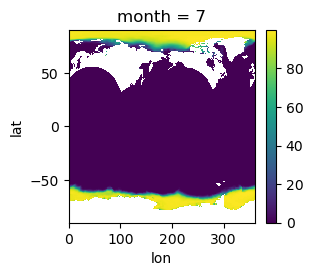

In [22]:
tmp = regrid_ice(sh_ice, 'sic_clim')
tmp2 = regrid_ice(nh_ice, 'sic_clim')
ice_tmp = tmp + tmp2

ice_tmp = ice_tmp.where(ones2==1)
ice_tmp.isel(month=7).plot(figsize=(3,2.5))

In [23]:
part1 = ice_tmp.where(ice_tmp>=0).sel(lon=slice(180,360))
part2 = ice_tmp.where(ice_tmp>=0).sel(lon=slice(0,180))

In [24]:
ice = np.full((12,180,360),1,dtype=int)

for month in np.arange(0,12,1):

    tmp = np.full((180,360),1,dtype=int)
    tmp[:,0:180] = part1.isel(month=month).values
    tmp[:,180:360] = part2.isel(month=month).values
    ice[month,:,:] = tmp
    
ice = xr.DataArray(ice,dims=('month','lat','lon'))
ice = ice.where(ones>=0, other=np.nan).where(ice>=0)

/glade/derecho/scratch/kristenk/tmp/ipykernel_72217/3345719188.py:6: RuntimeWarning: invalid value encountered in cast
  tmp[:,0:180] = part1.isel(month=month).values
/glade/derecho/scratch/kristenk/tmp/ipykernel_72217/3345719188.py:7: RuntimeWarning: invalid value encountered in cast
  tmp[:,180:360] = part2.isel(month=month).values


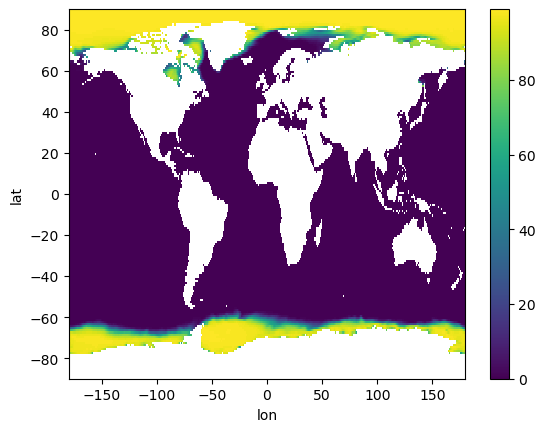

In [25]:
ice.isel(month=5).plot()

In [26]:
ice.attrs = ice_attrs

In [27]:
ds['Ice'] = ice.transpose("lat", "lon","month")

ds

<xarray.Dataset> Size: 19MB
Dimensions:  (lon: 360, lat: 180, month: 12)
Coordinates:
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * month    (month) float64 96B 1.0 2.0 3.0 4.0 5.0 ... 8.0 9.0 10.0 11.0 12.0
Data variables:
    MLD      (lat, lon, month) float64 6MB ...
    Chl      (lat, lon, month) float64 6MB nan nan nan nan ... nan nan nan nan
    Ice      (lat, lon, month) float64 6MB nan nan nan nan ... 98.0 98.0 98.0

## SST data

In [28]:
ny = 2160
nx = 4320

files = sorted(glob('/glade/work/kristenk/satellite_data/Monthly_clim_SST/??-A??????????????.L3m_MC_SST_sst_9km.nc'))
tlen=len(files)

modis_sst = np.full((tlen,ny,nx),-9999.)

t = 0
for file in files:
    ds_tmp = xr.open_dataset(file)
    modis_sst[t,:,:] = np.flipud(ds_tmp.sst.values)
    t = t + 1
sst_attrs = ds_tmp.sst.attrs
modis_sst = xr.DataArray(modis_sst, dims=('time','lat','lon'))

ds_sat_sst = xr.Dataset()
ds_sat_sst['sst'] = modis_sst

lat_data = np.arange(-90+1/24,90,1/12)
lon_data = np.arange(-180+1/24,180,1/12)

ds_sat_sst['lat'] = lat_data
ds_sat_sst['lon'] = lon_data
ds_sat_sst.sst.attrs = sst_attrs

In [29]:
def regrid_sst(ds_in, varname):
    
    lon = ds.lon.values
    lat = ds.lat.values
    
    ds_out = xr.Dataset({"lon": (["lon"], lon),"lat": (["lat"], lat)})

    def regrid_tracer(varname, ds_in, ds_out, method='bilinear'):
    
        regrid = xesmf.Regridder(
            ds_in,
            ds_out,
            method=method,
            periodic=True,
        )
        fld_out = regrid(ds_in[varname])
        return fld_out

    var_1x1 = regrid_tracer(varname, ds_in, ds_out)

    return(var_1x1)

In [30]:
sst = regrid_sst(ds_sat_sst, 'sst')
sst.attrs = sst_attrs

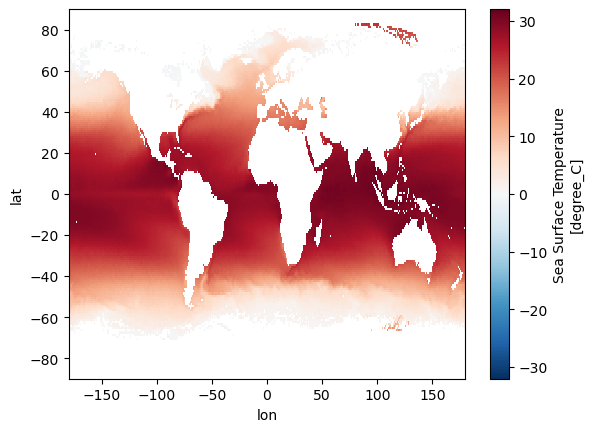

In [31]:
sst.isel(time=3).plot()

In [32]:
ds['SST'] = sst.transpose("lat", "lon", "time").rename({'time':'month'})

### Now check monthly climatologies for each of the 4 variables

In [33]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

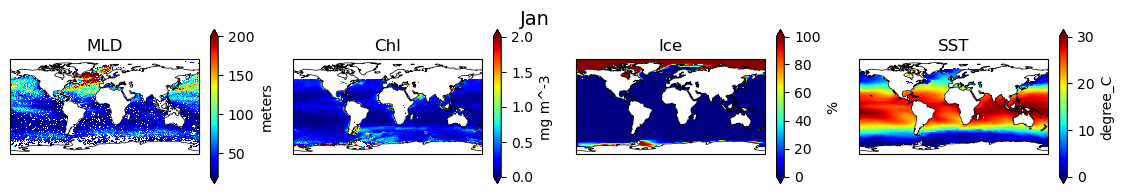

-----------------------------------------------------------------------------


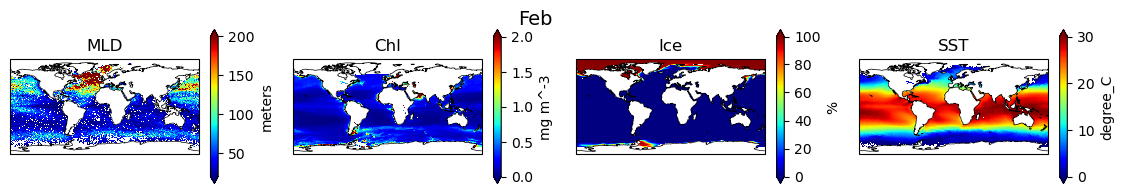

-----------------------------------------------------------------------------


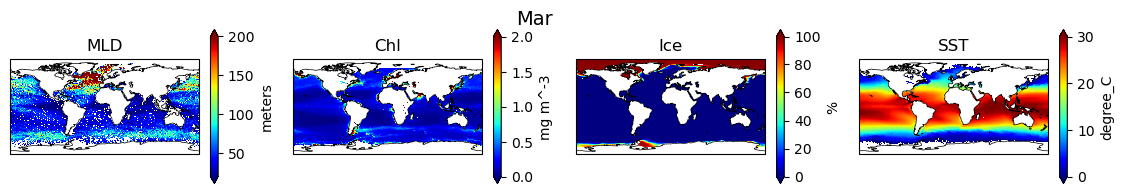

-----------------------------------------------------------------------------


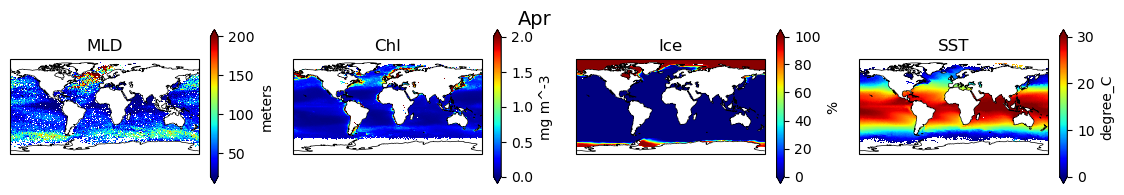

-----------------------------------------------------------------------------


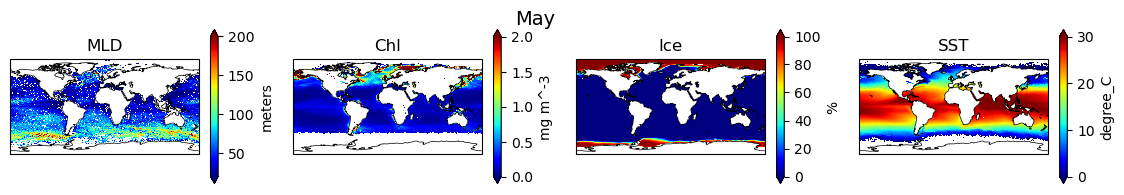

-----------------------------------------------------------------------------


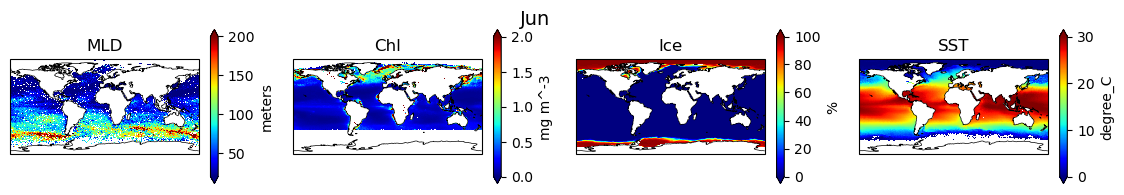

-----------------------------------------------------------------------------


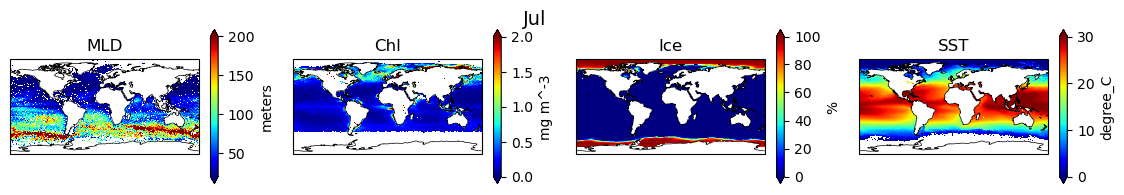

-----------------------------------------------------------------------------


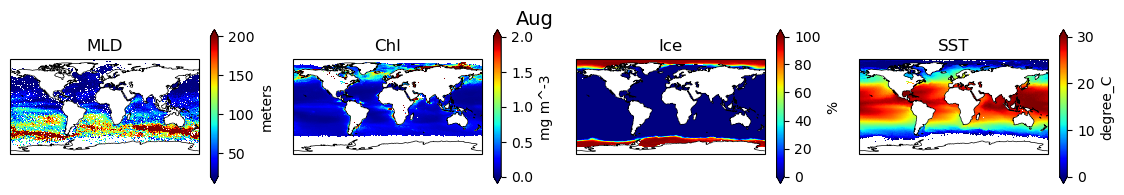

-----------------------------------------------------------------------------


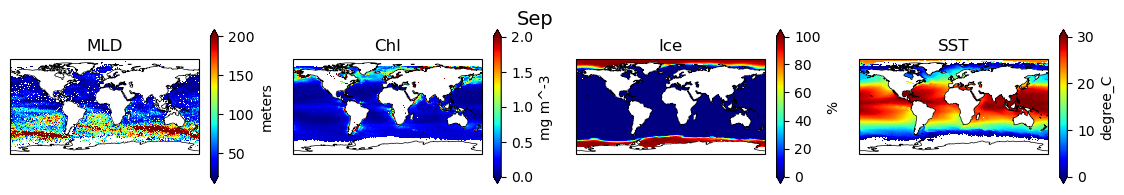

-----------------------------------------------------------------------------


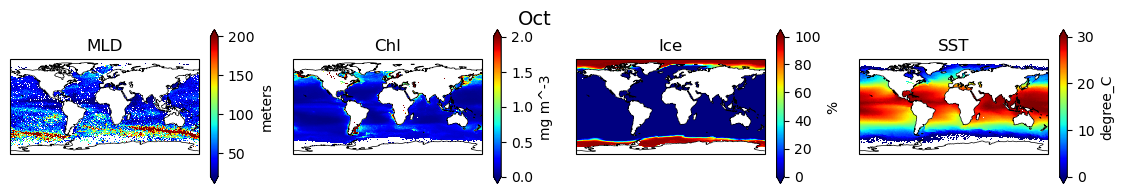

-----------------------------------------------------------------------------


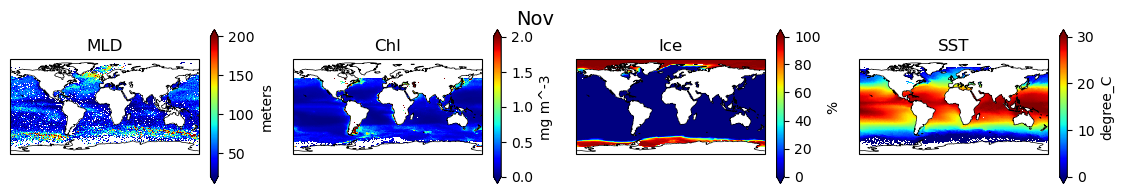

-----------------------------------------------------------------------------


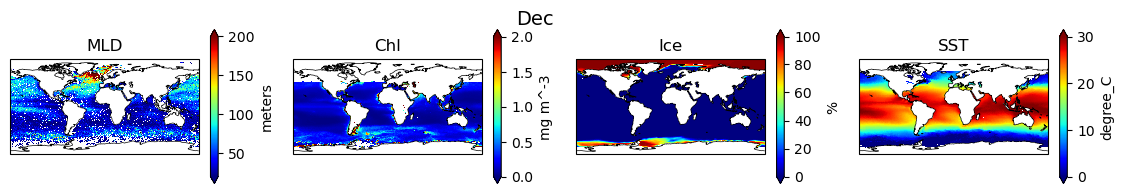

-----------------------------------------------------------------------------


In [34]:
for month in np.arange(1,13,1):

    fig = plt.figure(figsize=(14,2)) 
    plt.suptitle(months[month-1],fontsize=14)

    var = 'MLD'
    ax = fig.add_subplot(1,4,1,projection=ccrs.PlateCarree())
    ax.set_title(var)
    ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
    ax.coastlines('110m',linewidth=0.5)
    pc = ax.pcolormesh(ds.lon, ds.lat, ds[var].isel(month=month-1),
                       vmin=20,vmax=200,cmap='jet',
                       transform=ccrs.PlateCarree())
    cbar = fig.colorbar(pc, ax=ax,extend='both',label=ds[var].attrs['units'])
    
    #########################
    var = 'Chl'
    ax = fig.add_subplot(1,4,2,projection=ccrs.PlateCarree())
    ax.set_title(var)
    ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
    ax.coastlines('110m',linewidth=0.5)
    pc = ax.pcolormesh(ds.lon, ds.lat, ds[var].isel(month=month-1),
                       vmin=0,vmax=2,cmap='jet',
                       transform=ccrs.PlateCarree())
    cbar = fig.colorbar(pc, ax=ax,extend='both',label=ds[var].attrs['units'])

    #########################
    var = 'Ice'
    ax = fig.add_subplot(1,4,3,projection=ccrs.PlateCarree())
    ax.set_title(var)
    ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
    ax.coastlines('110m',linewidth=0.5)
    pc = ax.pcolormesh(ds.lon, ds.lat, ds[var].isel(month=month-1),
                       vmin=0,vmax=100,cmap='jet',
                       transform=ccrs.PlateCarree())
    cbar = fig.colorbar(pc, ax=ax,extend='both',label=ds[var].attrs['units'])


    #########################
    var = 'SST'
    ax = fig.add_subplot(1,4,4,projection=ccrs.PlateCarree())
    ax.set_title(var)
    ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
    ax.coastlines('110m',linewidth=0.5)
    pc = ax.pcolormesh(ds.lon, ds.lat, ds[var].isel(month=month-1),
                       vmin=0,vmax=30,cmap='jet',
                       transform=ccrs.PlateCarree())
    cbar = fig.colorbar(pc, ax=ax,extend='both',label=ds[var].attrs['units'])

    plt.show()
    print('-----------------------------------------------------------------------------')
    

## Looks good, now let's write out a netcdf

In [35]:
ds.to_netcdf('Obs4biomes.nc')